# Cat vs. Dog Image Classification
## Exercise 3: Feature Extraction and Fine-Tuning
**_Estimated completion time: 30 minutes_**

In Exercise 1, we built a convnet from scratch, and were able to achieve an accuracy of about 70%. With the addition of data augmentation and dropout in Exercise 2, we were able to increase accuracy to about 80%. That seems decent, but 20% is still too high of an error rate. Maybe we just don't have enough training data available to properly solve the problem. What other approaches can we try?

In this exercise, we'll look at two techniques for repurposing feature data generated from image models that have already been trained on large sets of data, **feature extraction** and **fine tuning**, and use them to improve the accuracy of our cat vs. dog classification model.

## Feature Extraction Using a Pretrained Model

One thing that is commonly done in computer vision is to take a model trained on a very large dataset, run it on your own, smaller dataset, and extract the intermediate representations (features) that the model generates. These representations are frequently informative for your own computer vision task, even though the task may be quite different from the problem that the original model was trained on. This versatility and repurposability of convnets is one of the most interesting aspects of deep learning.

In our case, we will use the [Inception V3 model](https://arxiv.org/abs/1512.00567) developed at Google, and pre-trained on [ImageNet](http://image-net.org/), a large dataset of web images (1.4M images and 1000 classes). This is a powerful model; let's see what the features that it has learned can do for our cat vs. dog problem.

First, we need to pick which intermediate layer of Inception V3 we will use for feature extraction. A common practice is to use the output of the very last layer before the `Flatten` operation, the so-called "bottleneck layer." The reasoning here is that the following fully connected layers will be too specialized for the task the network was trained on, and thus the features learned by these layers won't be very useful for a new task. The bottleneck features, however, retain much generality.

Let's instantiate an Inception V3 model preloaded with weights trained on ImageNet:


In [1]:
import os

# Import necessary packages.
import numpy as np
import pandas as pd
import torch
import os
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
from torchvision.datasets import ImageFolder, DatasetFolder, VisionDataset

# This is for the progress bar.
from tqdm.auto import tqdm
import random

In [2]:
# !mkdir tmp
# !wget --no-check-certificate \
#     https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
#     -O ./tmp/cats_and_dogs_filtered.zip

In [3]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()
  
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

In [4]:
train_tfm = transforms.Compose([        
    # transforms.Resize((150, 150)),
    # transforms.RandomAffine(degrees=40, scale=(0.8, 0.8), translate=(0.2, 0.2), shear=0.2),
    # transforms.RandomHorizontalFlip(p=0.5),  
    # transforms.ToTensor(), # range [0, 255] -> [0.0,1.0]
    # transforms.Normalize(mean=[0.4, 0.4, 0.4], std=[0.2, 0.2, 0.2])
    
    transforms.Resize((299, 299)),
    transforms.CenterCrop((299, 299)),
    transforms.ToTensor(), # range [0, 255] -> [0.0,1.0]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_tfm = transforms.Compose([        
    # transforms.Resize((150, 150)), 
    # transforms.ToTensor(), # range [0, 255] -> [0.0,1.0]
    
    transforms.Resize((150, 150)),
    # transforms.CenterCrop((299, 299)),
    transforms.ToTensor(), # range [0, 255] -> [0.0,1.0]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_set = ImageFolder(root=train_dir, transform = train_tfm)
val_set = ImageFolder(root=validation_dir, transform = test_tfm)

Finally, let's train the model using the features we extracted. We'll train on all 2000 images available, for 2 epochs, and validate on all 1,000 validation images.

In [5]:
batch_size=20
# The following variables are the hyperparameters.
learning_rate = 0.001
n_epochs = 2



train_loader=DataLoader(train_set,batch_size=batch_size,shuffle=True)
valid_loader=DataLoader(val_set,batch_size=batch_size,shuffle=True)

**NOTE:** The 2,000 images used in this exercise are excerpted from the ["Dogs vs. Cats" dataset](https://www.kaggle.com/c/dogs-vs-cats/data) available on Kaggle, which contains 25,000 images. Here, we use a subset of the full dataset to decrease training time for educational purposes.

In [6]:
# !mkdir tmp
# !wget --no-check-certificate \
#     https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
#     -O ./tmp/cats_and_dogs_filtered.zip

Now let's download the weights:

In [7]:
# model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
# model

from torchvision import models
model = models.inception_v3(pretrained=True)

In [8]:
model.aux_logits = False

for parameter in model.parameters():
    parameter.requires_grad = False
    
    
# model.fc = nn.Sequential(
#     nn.Flatten(), 
#     nn.Linear(model.fc.in_features, 1024),
#     nn.ReLU(),
#     nn.Dropout(0.2),
#     nn.Linear(1024, 1),
#     nn.Sigmoid()        # 表示第i个样本的经过sigmoid的预测概率  
# )   

model.fc = nn.Sequential(
    nn.Flatten(), 
    nn.Linear(model.fc.in_features, 800),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(800, 1),
    nn.Sigmoid()        # 表示第i个样本的经过sigmoid的预测概率  
)   

device = "cuda" if torch.cuda.is_available() else "cpu"

model = model.to(device)

optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)


Let's make the model non-trainable, since we will only use it for feature extraction; we won't update the weights of the pretrained model during training.

In [9]:
model

from torchinfo import summary
# summary(model, input_size=(20, 3, 150, 150))

The layer we will use for feature extraction in Inception v3 is called `mixed7`. It is not the bottleneck of the network, but we are using it to keep a sufficiently large feature map (7x7 in this case). (Using the bottleneck layer would have resulting in a 3x3 feature map, which is a bit small.) Let's get the output from `mixed7`:

In [10]:
from torch.autograd import Variable


loss_func = nn.BCELoss() 
    
epoch_train_loss = []

epoch_valid_loss = []

epoch_train_acc = []

epoch_valid_acc = []

    
for epoch in range(n_epochs):
    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []    
    
    # for batch in tqdm(trainloader):
    for batch in tqdm(train_loader):
        X, y = batch 
        # print(X.shape) # torch.Size([5, 3, 150, 150])
        X = Variable(X).to(device)  
        y = Variable(y).type(torch.FloatTensor).unsqueeze(1).to(device)
        # print(X.shape)
        y_hat = model(X)       
        
        loss = loss_func(y_hat, y) #rmse
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()      
        
        pred = (y_hat >= 0.5)
        acc = (pred == y).sum() / len(y)
        
        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)
        
    train_loss = sum(train_loss) / len(train_loss)
    train_accs = sum(train_accs) / len(train_accs)
    
    epoch_train_loss.append(train_loss)
    epoch_train_acc.append(train_accs)
   
    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()
    
    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []
    
    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):
        X, y = batch   
        X = Variable(X).to(device)  
        y = Variable(y).type(torch.FloatTensor).unsqueeze(1).to(device) 
        y_hat = model(X)
        loss = loss_func(y_hat, y) #rmse
        
        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        
        pred = (y_hat >= 0.5)
        acc = (pred == y).sum() / len(y) 
        
        valid_accs.append(acc)
        
     # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_accs = sum(valid_accs) / len(valid_accs)
    epoch_valid_loss.append(valid_loss)
    epoch_valid_acc.append(valid_accs)
        
    # Print the information.
    print(f"[ Epoch | {epoch + 1:03d}/{n_epochs:03d} ] \
          train_loss = {train_loss:.5f} accuracy = {train_accs:.5f}  | \
          valid_loss = {valid_loss:.5f} val_accuracy = {valid_accs:.5f}")

print("Defined the build_model and train_model functions.")


[ Epoch | 001/002 ]           train_loss = 0.57045 accuracy = 0.86800  |           valid_loss = 0.71951 val_accuracy = 0.87500



[ Epoch | 002/002 ]           train_loss = 0.19450 accuracy = 0.92400  |           valid_loss = 0.69419 val_accuracy = 0.89500
Defined the build_model and train_model functions.


You can see that we reach a validation accuracy of 88–90% very quickly. This is much better than the small model we trained from scratch.

## Further Improving Accuracy with Fine-Tuning

In our feature-extraction experiment, we only tried adding two classification layers on top of an Inception V3 layer. The weights of the pretrained network were not updated during training. One way to increase performance even further is to "fine-tune" the weights of the top layers of the pretrained model alongside the training of the top-level classifier. A couple of important notes on fine-tuning:

- **Fine-tuning should only be attempted *after* you have trained the top-level classifier with the pretrained model set to non-trainable**. If you add a randomly initialized classifier on top of a pretrained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier), and your pretrained model will just forget everything it has learned.
- Additionally, we **fine-tune only the *top layers* of the pre-trained model** rather than all layers of the pretrained model because, in a convnet, the higher up a layer is, the more specialized it is. The first few layers in a convnet learn very simple and generic features, which generalize to almost all types of images. But as you go higher up, the features are increasingly specific to the dataset that the model is trained on. The goal of fine-tuning is to adapt these specialized features to work with the new dataset.

All we need to do to implement fine-tuning is to set the top layers of Inception V3 to be trainable, recompile the model (necessary for these changes to take effect), and resume training. Let's unfreeze all layers belonging to the `mixed7` module—i.e., all layers found after `mixed6`—and recompile the model:

In [11]:
batch_size=20
# The following variables are the hyperparameters.
learning_rate = 0.00001
n_epochs = 50

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [12]:
from torch.autograd import Variable


loss_func = nn.BCELoss() 
    
epoch_train_loss = []

epoch_valid_loss = []

epoch_train_acc = []

epoch_valid_acc = []

    
for epoch in range(n_epochs):
    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []    
    
    # for batch in tqdm(trainloader):
    for batch in tqdm(train_loader):
        X, y = batch 
        # print(X.shape) # torch.Size([5, 3, 150, 150])
        X = Variable(X).to(device)  
        y = Variable(y).type(torch.FloatTensor).unsqueeze(1).to(device)
        # print(X.shape)
        y_hat = model(X)       
        
        loss = loss_func(y_hat, y) #rmse
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()      
        
        pred = (y_hat >= 0.5)
        acc = (pred == y).sum() / len(y)
        
        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)
        
    train_loss = sum(train_loss) / len(train_loss)
    train_accs = sum(train_accs) / len(train_accs)
    
    epoch_train_loss.append(train_loss)
    epoch_train_acc.append(train_accs)
   
    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()
    
    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []
    
    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):
        X, y = batch   
        X = Variable(X).to(device)  
        y = Variable(y).type(torch.FloatTensor).unsqueeze(1).to(device) 
        y_hat = model(X)
        loss = loss_func(y_hat, y) #rmse
        
        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        
        pred = (y_hat >= 0.5)
        acc = (pred == y).sum() / len(y) 
        
        valid_accs.append(acc)
        
     # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_accs = sum(valid_accs) / len(valid_accs)
    epoch_valid_loss.append(valid_loss)
    epoch_valid_acc.append(valid_accs)
        
    # Print the information.
    print(f"[ Epoch | {epoch + 1:03d}/{n_epochs:03d} ] \
          train_loss = {train_loss:.5f} accuracy = {train_accs:.5f}  | \
          valid_loss = {valid_loss:.5f} val_accuracy = {valid_accs:.5f}")

print("Defined the build_model and train_model functions.")


[ Epoch | 001/050 ]           train_loss = 0.12726 accuracy = 0.95450  |           valid_loss = 0.50812 val_accuracy = 0.91000



[ Epoch | 002/050 ]           train_loss = 0.12242 accuracy = 0.95450  |           valid_loss = 0.72753 val_accuracy = 0.88900



[ Epoch | 003/050 ]           train_loss = 0.10515 accuracy = 0.96700  |           valid_loss = 0.67265 val_accuracy = 0.90100



[ Epoch | 004/050 ]           train_loss = 0.10717 accuracy = 0.96250  |           valid_loss = 0.80498 val_accuracy = 0.89300



[ Epoch | 005/050 ]           train_loss = 0.11096 accuracy = 0.95800  |           valid_loss = 0.71175 val_accuracy = 0.89400



[ Epoch | 006/050 ]           train_loss = 0.11578 accuracy = 0.96000  |           valid_loss = 0.54692 val_accuracy = 0.90400



[ Epoch | 007/050 ]           train_loss = 0.11177 accuracy = 0.96450  |           valid_loss = 0.58059 val_accuracy = 0.90200



[ Epoch | 008/050 ]           train_loss = 0.10260 accuracy = 0.95450  |           valid_loss = 0.55294 val_accuracy = 0.90100



[ Epoch | 009/050 ]           train_loss = 0.11029 accuracy = 0.96050  |           valid_loss = 0.55973 val_accuracy = 0.90600



[ Epoch | 010/050 ]           train_loss = 0.11867 accuracy = 0.95900  |           valid_loss = 0.68751 val_accuracy = 0.90100



[ Epoch | 011/050 ]           train_loss = 0.11230 accuracy = 0.95850  |           valid_loss = 0.51141 val_accuracy = 0.90600



[ Epoch | 012/050 ]           train_loss = 0.11325 accuracy = 0.95900  |           valid_loss = 0.70253 val_accuracy = 0.90000



[ Epoch | 013/050 ]           train_loss = 0.10141 accuracy = 0.96250  |           valid_loss = 0.55841 val_accuracy = 0.89900



[ Epoch | 014/050 ]           train_loss = 0.11212 accuracy = 0.96200  |           valid_loss = 0.65589 val_accuracy = 0.90300



[ Epoch | 015/050 ]           train_loss = 0.11370 accuracy = 0.95550  |           valid_loss = 0.66789 val_accuracy = 0.90700



[ Epoch | 016/050 ]           train_loss = 0.11719 accuracy = 0.95600  |           valid_loss = 0.67599 val_accuracy = 0.90400



[ Epoch | 017/050 ]           train_loss = 0.11584 accuracy = 0.95700  |           valid_loss = 0.73196 val_accuracy = 0.89700



[ Epoch | 018/050 ]           train_loss = 0.11990 accuracy = 0.95750  |           valid_loss = 0.52288 val_accuracy = 0.90900



[ Epoch | 019/050 ]           train_loss = 0.11880 accuracy = 0.95250  |           valid_loss = 0.55596 val_accuracy = 0.90400



[ Epoch | 020/050 ]           train_loss = 0.11705 accuracy = 0.95550  |           valid_loss = 0.54679 val_accuracy = 0.90500



[ Epoch | 021/050 ]           train_loss = 0.11966 accuracy = 0.95850  |           valid_loss = 0.69348 val_accuracy = 0.90000



[ Epoch | 022/050 ]           train_loss = 0.13570 accuracy = 0.94500  |           valid_loss = 0.67826 val_accuracy = 0.90600



[ Epoch | 023/050 ]           train_loss = 0.11704 accuracy = 0.95550  |           valid_loss = 0.63611 val_accuracy = 0.90900



[ Epoch | 024/050 ]           train_loss = 0.10854 accuracy = 0.96050  |           valid_loss = 0.80906 val_accuracy = 0.89600



[ Epoch | 025/050 ]           train_loss = 0.10756 accuracy = 0.96100  |           valid_loss = 0.69548 val_accuracy = 0.89800



[ Epoch | 026/050 ]           train_loss = 0.11068 accuracy = 0.95700  |           valid_loss = 0.65704 val_accuracy = 0.90400



[ Epoch | 027/050 ]           train_loss = 0.11096 accuracy = 0.96350  |           valid_loss = 0.53736 val_accuracy = 0.90700



[ Epoch | 028/050 ]           train_loss = 0.11132 accuracy = 0.96050  |           valid_loss = 0.66163 val_accuracy = 0.90100



[ Epoch | 029/050 ]           train_loss = 0.11864 accuracy = 0.95650  |           valid_loss = 0.72097 val_accuracy = 0.89700



[ Epoch | 030/050 ]           train_loss = 0.12442 accuracy = 0.95350  |           valid_loss = 0.80395 val_accuracy = 0.89400



[ Epoch | 031/050 ]           train_loss = 0.12179 accuracy = 0.95850  |           valid_loss = 0.61192 val_accuracy = 0.90300



[ Epoch | 032/050 ]           train_loss = 0.12391 accuracy = 0.95100  |           valid_loss = 0.64563 val_accuracy = 0.90200



[ Epoch | 033/050 ]           train_loss = 0.11885 accuracy = 0.95600  |           valid_loss = 0.55246 val_accuracy = 0.90000



[ Epoch | 034/050 ]           train_loss = 0.10221 accuracy = 0.96000  |           valid_loss = 0.69825 val_accuracy = 0.89700



[ Epoch | 035/050 ]           train_loss = 0.12044 accuracy = 0.95700  |           valid_loss = 0.70137 val_accuracy = 0.89600



[ Epoch | 036/050 ]           train_loss = 0.11698 accuracy = 0.95850  |           valid_loss = 0.75243 val_accuracy = 0.89500



[ Epoch | 037/050 ]           train_loss = 0.12860 accuracy = 0.95200  |           valid_loss = 0.68126 val_accuracy = 0.90200



[ Epoch | 038/050 ]           train_loss = 0.10439 accuracy = 0.96050  |           valid_loss = 0.68443 val_accuracy = 0.89700



[ Epoch | 039/050 ]           train_loss = 0.12291 accuracy = 0.95400  |           valid_loss = 0.66873 val_accuracy = 0.90300



[ Epoch | 040/050 ]           train_loss = 0.12392 accuracy = 0.95750  |           valid_loss = 0.89945 val_accuracy = 0.88900



[ Epoch | 041/050 ]           train_loss = 0.11335 accuracy = 0.95700  |           valid_loss = 0.68934 val_accuracy = 0.90300



[ Epoch | 042/050 ]           train_loss = 0.11999 accuracy = 0.95750  |           valid_loss = 0.58394 val_accuracy = 0.90500



[ Epoch | 043/050 ]           train_loss = 0.11330 accuracy = 0.95500  |           valid_loss = 0.74478 val_accuracy = 0.90000



[ Epoch | 044/050 ]           train_loss = 0.10106 accuracy = 0.96250  |           valid_loss = 0.54344 val_accuracy = 0.90700



[ Epoch | 045/050 ]           train_loss = 0.11454 accuracy = 0.95500  |           valid_loss = 0.53342 val_accuracy = 0.90700



[ Epoch | 046/050 ]           train_loss = 0.10030 accuracy = 0.96350  |           valid_loss = 0.70074 val_accuracy = 0.89900



[ Epoch | 047/050 ]           train_loss = 0.10574 accuracy = 0.96150  |           valid_loss = 0.67844 val_accuracy = 0.90300



[ Epoch | 048/050 ]           train_loss = 0.11218 accuracy = 0.95650  |           valid_loss = 0.93225 val_accuracy = 0.89200



[ Epoch | 049/050 ]           train_loss = 0.13220 accuracy = 0.94600  |           valid_loss = 0.71356 val_accuracy = 0.90000



[ Epoch | 050/050 ]           train_loss = 0.12118 accuracy = 0.95250  |           valid_loss = 0.54147 val_accuracy = 0.90300
Defined the build_model and train_model functions.


We are seeing a nice improvement, with the validation loss going from ~1.7 down to ~1.2, and accuracy going from 88% to 92%. That's a 4.5% relative improvement in accuracy.

Let's plot the training and validation loss and accuracy to show it conclusively:

Text(0.5, 1.0, 'Training and validation loss')

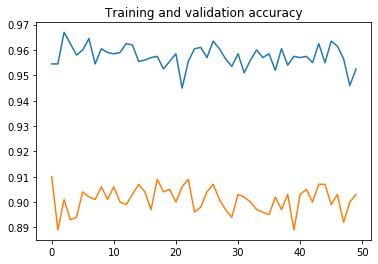

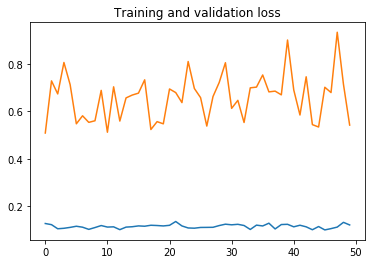

In [13]:
import matplotlib.pyplot as plt

# Get number of epochs
epochs = range(len(epoch_train_acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, epoch_train_acc)
plt.plot(epochs, epoch_valid_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, epoch_train_loss)
plt.plot(epochs, epoch_valid_loss)
plt.title('Training and validation loss')

Congratulations! Using feature extraction and fine-tuning, you've built an image classification model that can identify cats vs. dogs in images with over 90% accuracy.

## Clean Up

Run the following cell to terminate the kernel and free memory resources:

In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)